In [71]:
import re

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn import utils
from pymystem3 import Mystem
from string import punctuation
from nltk.corpus import stopwords
from gensim.models import Doc2Vec
from keras.preprocessing.text import Tokenizer
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
tqdm.pandas(desc="progress-bar")

Read books

In [72]:
book_1 = open("books_ru/poems/Blok/Возмездие.txt", "r")
book_2 = open("books_ru/poems/Lermontov/Ангел.txt", "r")

#arr = np.array()
df = pd.DataFrame({"Author": ["Blok", "Lermontov"], "Text": [book_1.read(), book_2.read()]})

#df = pd.read_csv('all-data.csv',delimiter=',',encoding='latin-1')
#TODO: read to df -> books_en/Shakespeare/THE TRAGEDY OF ROMEO AND JULIET.txt
book_1.close()
book_2.close()
df.head()

,Author,Text
0,Blok,Александр Блок\n\n\nВОЗМЕЗДИЕ\n\n\n ...
1,Lermontov,Михаил Лермонтов\nАНГЕЛ\nПо небу полуночи анге...


Clean text from punctuation

In [73]:
russian_stopwords = stopwords.words('russian')
mystem = Mystem()
#Preprocess function

def preprocess_text(text):
    text = re.sub(r'[\n.+*"\'-]+', ' ', text)
    text = re.sub(r' {2,}', ' ', text)

    lemmas = mystem.lemmatize(text.lower())
    tokens = [token for token in lemmas if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]

    text = " ".join(tokens)

    return text

for i in range(len(df)):
    #words = df['Text'][i].split()
    #table = str.maketrans('', '', string.punctuation)
    #stripped = [w.translate(table) for w in words]
    df['Text'][i] = preprocess_text(df['Text'][i])

df.head()

,Author,Text
0,Blok,александр блок возмездие юность это возмездие ...
1,Lermontov,михаил лермонтов ангел небо полночь ангел лете...


VISUALIZING THE DATA

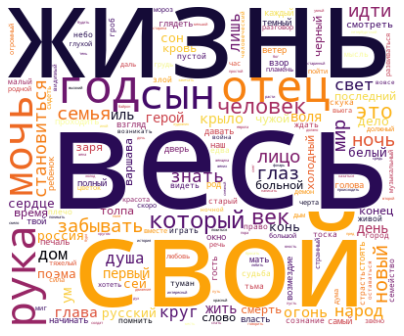

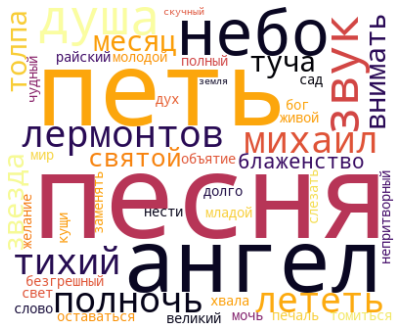

In [74]:
from wordcloud import WordCloud
#cmaps=['viridis', 'plasma', 'inferno', 'magma', 'cividis']
for book in df['Text']:
    wordcloud = WordCloud(background_color="white",
                          stopwords=russian_stopwords,
                          mode="RGBA",
                          width=400,
                          height=330,
                          colormap='inferno').generate(book)
    # Display the generated image:
    plt.figure(figsize=[7,7])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Count and visualize as barplots

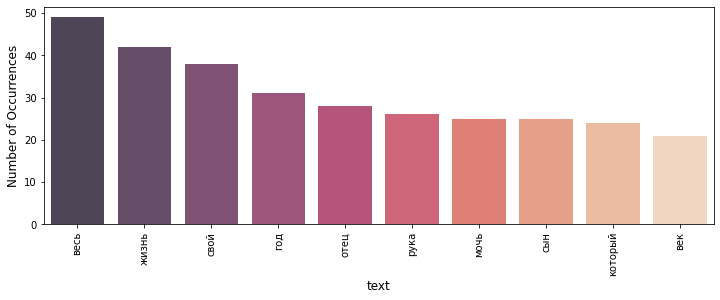

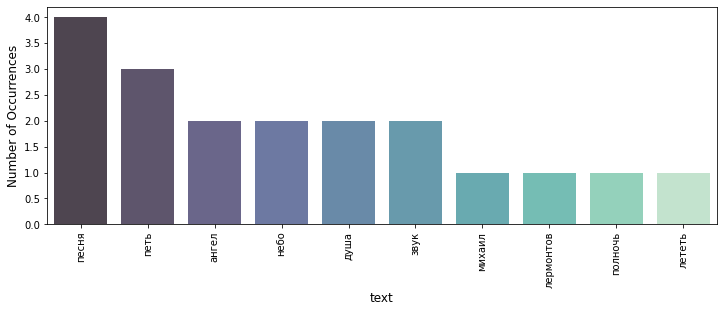

In [87]:
from collections import Counter
sns_palette = ["rocket", "mako", "magma", "rocket_r"]
for i, book in enumerate(df['Text']):
    cnt_pro = np.asarray(Counter(book.split()).most_common(10))
    occ_df = pd.DataFrame({'word': cnt_pro[:, 0], 'count': [int(num) for num in cnt_pro[:, 1]]})
    plt.figure(figsize=(12,4))
    sns.barplot(x='word', y='count', alpha=0.8, data=occ_df, palette=sns_palette[i])
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('text', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [7]:
#Convert sting to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

df.sentiment = [sentiment[item] for item in df.sentiment] 
print(df)

      sentiment                                            Message
0             1  Technopolis plans to develop in stages an area...
1             2  The international electronic industry company ...
2             0  With the new production plant the company woul...
3             0  According to the company 's updated strategy f...
4             0  FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...         ...                                                ...
4840          2  LONDON MarketWatch -- Share prices ended lower...
4841          1  Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842          2  Operating profit fell to EUR 35.4 mn from EUR ...
4843          2  Net sales of the Paper segment decreased to EU...
4844          2  Sales in Finland decreased by 10.5 % in Januar...

[4845 rows x 2 columns]


In [8]:
def print_message(index):
    example = df[df.index == index][['Message', 'sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Message:', example[1])
print_message(12)

Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .
Message: 0


In [9]:
print_message(0)

Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .
Message: 1


Text Preprocessing Below we define a function to convert text to lower-case and strip punctuation/symbols from words and so on.

In [ ]:
from bs4 import BeautifulSoup
def clean_text(text):
    text = BeautifulSoup(text, "html").text
    text = re.sub(r'\|\|\|', r' ', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Message'] = df['Message'].apply(clean_text)

In [11]:
df['Message'] = df['Message'].apply(clean_text)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)
import nltk
nltk.download('punkt')

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_features = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Chrysalis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Found 4845 unique tokens.


In [12]:
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (4845, 50)


In [13]:
#train_tagged.values[2173]
train_tagged.values

array([TaggedDocument(words=['upm-kymmene', 'has', 'generated', 'four', 'consecutive', 'quarters', 'of', 'positive', 'free', 'cash', 'flow', '.'], tags=[0]),
       TaggedDocument(words=['in', 'the', 'method', 'the', 'smelt', 'spouts', '2', 'are', 'separated', 'from', 'the', 'working', 'area', '6', 'by', 'a', 'shielding', 'wall', '8', ',', '10', 'arranged', 'movable', 'in', 'relation', 'to', 'the', 'smelt', 'spouts', '.'], tags=[1]),
       TaggedDocument(words=['``', 'that', "'s", 'a', 'very', 'high', 'figure', 'on', 'the', 'european', 'scale', ',', '``', 'noop', 'said', ',', 'recalling', 'however', 'that', 'this', 'also', 'includes', 'beer', 'bought', 'by', 'finnish', 'tourists', '.'], tags=[1]),
       ...,
       TaggedDocument(words=['proha', 'plc', '(', 'euronet', ':7327', ')', 'announced', 'today', '(', '19', 'may', ')', 'that', 'its', 'fully-owned', 'subsidiary', ',', 'safran', 'software', 'solutions', 'as', ',', 'has', 'agreed', 'to', 'sell', 'its', '49', '%', 'share', 'of', '

Model DM = 1

This work use DM=1 (it preserves word order)

In [14]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])


100%|██████████| 4844/4844 [00:00<00:00, 4876910.36it/s]


In [15]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4844/4844 [00:00<00:00, 5042742.26it/s]


Wall time: 5.73 s


In [16]:
print(d2v_model)

Doc2Vec(dm/m,d20,n5,w8,s0.001)


In [17]:
len(d2v_model.wv.vocab)

11682

In [18]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec
    #print(vec)
    #print(vec[i])

# Measuring distance between two vectors (related to cosine similarity)

In [19]:
d2v_model.wv.most_similar(positive=['profit'], topn=10)


[('loss', 0.8851058483123779),
 ('income', 0.7569829821586609),
 ('sacanfil', 0.7506617307662964),
 ('mistake', 0.7386969923973083),
 ('eur121m', 0.7272866368293762),
 ('contribution', 0.7168368101119995),
 ('rap1v', 0.71683669090271),
 ('profits', 0.707839846611023),
 ('mechanics', 0.706662654876709),
 ('.27', 0.693638801574707)]

In [20]:
d2v_model.wv.most_similar(positive=['investment'], topn=10)


[('sinappi', 0.7542585134506226),
 ('demanded', 0.7437744140625),
 ('honkajoki', 0.73475182056427),
 ('unilever', 0.7343888282775879),
 ('refineries', 0.7249599099159241),
 ('12.6', 0.7175784707069397),
 ('seudun', 0.7171003818511963),
 ('niklas', 0.7084669470787048),
 ('syndicated', 0.6951124668121338),
 ('aeronautic', 0.687085747718811)]

In [21]:
d2v_model.wv.most_similar(positive=['broke'], topn=10)

[('mold', 0.9816063642501831),
 ('brockpahler', 0.8891646862030029),
 ('mika', 0.8791223764419556),
 ('kelly', 0.8786339163780212),
 ('aboavista', 0.8629003763198853),
 ('bnamericas', 0.8506964445114136),
 ('mda', 0.8382914066314697),
 ('maatta', 0.8225914239883423),
 ('want', 0.8158885836601257),
 ('frank', 0.8078140020370483)]

Plot Similarity word in Doc2vec

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(model_to_plot):
    """Creates and TSNE model and plots it"""
    plot_labels = []
    tokens = []

    for word in d2v_model.wv.vocab:
        tokens.append(model_to_plot[word])
        plot_labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for k in range(len(x)):
        plt.scatter(x[k],y[k])
        plt.annotate(plot_labels[k],
                     xy=(x[k], y[k]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [23]:
#tsne_plot(d2v_model)

# Create the LSTM Model

The parameter used here inspired by [3].

In [24]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

# init layer
model = Sequential()

# embed word vectors
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 20)            233660    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                14200     
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 248,013
Trainable params: 248,013
Non-trainable params: 0
_________________________________________________________________


In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [26]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4118, 50) (4118, 3)
(727, 50) (727, 3)


In [27]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
129/129 - 9s - loss: 0.5611 - acc: 0.5935
Epoch 2/50
129/129 - 1s - loss: 0.4239 - acc: 0.6977
Epoch 3/50
129/129 - 1s - loss: 0.2989 - acc: 0.7946
Epoch 4/50
129/129 - 1s - loss: 0.2057 - acc: 0.8635
Epoch 5/50
129/129 - 1s - loss: 0.1256 - acc: 0.9395
Epoch 6/50
129/129 - 1s - loss: 0.1118 - acc: 0.9490
Epoch 7/50
129/129 - 1s - loss: 0.0637 - acc: 0.9721
Epoch 8/50
129/129 - 1s - loss: 0.0470 - acc: 0.9791
Epoch 9/50
129/129 - 1s - loss: 0.0396 - acc: 0.9847
Epoch 10/50
129/129 - 1s - loss: 0.0362 - acc: 0.9852
Epoch 11/50
129/129 - 1s - loss: 0.0269 - acc: 0.9908
Epoch 12/50
129/129 - 1s - loss: 0.0275 - acc: 0.9871
Epoch 13/50
129/129 - 1s - loss: 0.0220 - acc: 0.9900
Epoch 14/50
129/129 - 1s - loss: 0.0186 - acc: 0.9922
Epoch 15/50
129/129 - 1s - loss: 0.0171 - acc: 0.9930
Epoch 16/50
129/129 - 1s - loss: 0.0123 - acc: 0.9959
Epoch 17/50
129/129 - 1s - loss: 0.0115 - acc: 0.9951
Epoch 18/50
129/129 - 1s - loss: 0.0102 - acc: 0.9949
Epoch 19/50
129/129 - 1s - loss: 0.00

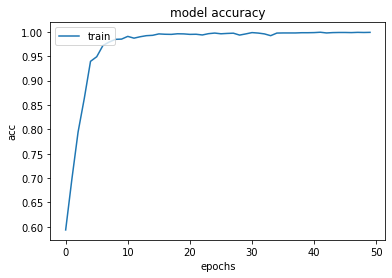

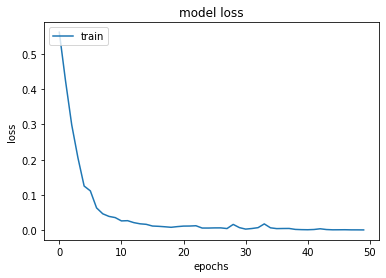

<Figure size 432x288 with 0 Axes>

In [28]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [29]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 1s - loss: 9.5799e-04 - acc: 0.9998
23/23 - 0s - loss: 1.5023 - acc: 0.7125
Train: 1.000, Test: 0.7125


In [31]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1) #  model.predict_classes(X_test, verbose=0)
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

[[8.0932714e-06 9.9999070e-01 1.1958724e-06]
 [1.0000000e+00 2.9387577e-09 7.4972419e-09]
 [3.5694583e-10 1.0000000e+00 7.1814343e-10]
 ...
 [1.3110305e-04 8.2853076e-05 9.9978608e-01]
 [4.4137163e-10 1.0000000e+00 5.9870747e-10]
 [1.0000000e+00 3.1912024e-09 3.2976366e-09]]
[1 0 1 1 1 1 1 1 1 1 1 1 0 2 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 2 1 1 1 2 1 0 1
 0 1 1 0 1 0 1 0 1 1 1 0 1 2 1 2 2 1 0 1 1 0 1 0 0 2 0 1 1 1 1 1 0 1 0 0 1
 0 1 1 1 1 0 1 2 0 1 0 0 1 0 1 0 0 1 1 2 1 1 0 1 1 1 2 1 1 2 0 0 1 1 2 1 1
 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 2 1 0 1 0 1 1 1 1 0 1 0 1 1 2 1
 2 1 1 1 1 1 1 0 0 1 2 1 0 1 1 0 1 0 1 2 1 0 1 0 0 1 0 2 0 0 1 0 1 0 1 1 1
 2 1 2 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 2 1 1 0 1
 1 1 1 1 1 0 1 1 1 0 1 1 2 2 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 2 1 0 1 1 1
 1 1 0 1 0 2 2 0 1 1 1 1 1 2 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 2 1
 1 1 0 1 0 1 2 1 1 2 1 0 1 0 1 2 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1
 1 0 2 1 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 0 2 1 1 0 

In [32]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0, 1, 0, 0, 2, 2, 1,
       0, 0, 1, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 1, 2, 1,
       0, 1, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 2, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 2, 2, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 1, 0, 0, 1, 0, 2, 1,
       2, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 1,
       0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0,

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[129,  80,   6],
       [ 66, 341,  19],
       [  9,  29,  48]], dtype=int64)

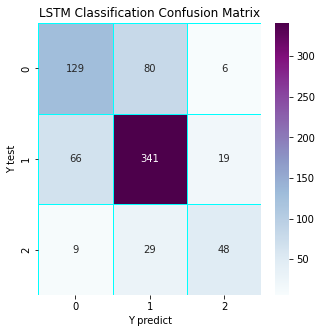

In [34]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

# Validation

In [35]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" %score)
print("acc: %.2f" %acc)

4/4 [==============================] - 0s 7ms/step - loss: 1.5822 - acc: 0.7094
score: 1.58
acc: 0.71


**Save Model**

In [36]:
model.save('Mymodel.h5')

**Test with new and different data set aside from the data to build the model.**

note : sentiment  = {'positive': 0,'neutral': 1,'negative':2} 

In [37]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[0.07872527 0.0322215  0.88905317]] 2


In [38]:
message = ['such massive asteroid hit will certainly create new business opportunities']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[9.9997079e-01 2.1883559e-05 7.3230444e-06]] 0


In [39]:
message = ['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[6.1022658e-12 1.0000000e+00 5.6711246e-12]] 1


In [40]:
message = ['@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[6.9639857e-05 9.9992907e-01 1.3543212e-06]] 1


In [41]:
message = ['The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[1.7782825e-10 1.0000000e+00 1.3231644e-10]] 1


In [42]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[2.6333930e-07 5.3379125e-08 9.9999964e-01]] 2
